In [ ]:
import pandas as pd

# Load the data into a DataFrame
# Assuming the data is in a CSV file named 'stock_data.csv' in the current directory
# Replace 'stock_data.csv' with the actual path to your data file
try:
    full_df = pd.read_csv('stock_data.csv')
except FileNotFoundError:
    print("Error: 'stock_data.csv' not found. Please update the code with the correct file path.")

Error: 'stock_data.csv' not found. Please update the code with the correct file path.


In [ ]:
!pip install yfinance
!pip install pandas-datareader
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install prophet
!pip install tensorflow
!pip install keras

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install tensorflow

In [ ]:
!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 10.6 MB/s eta 0:00:00


In [ ]:
# นำเข้าไลบรารีที่จำเป็น
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, SGDRegressor, PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_squared_error,  # เก็บไว้สำหรับคำนวณ RMSE
    mean_absolute_percentage_error,
    max_error,
    median_absolute_error,
    explained_variance_score
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# -----------------------------------------------------------------------------
# 1. ดาวน์โหลดข้อมูลหุ้นหลายตัว
# -----------------------------------------------------------------------------
tickers = ["AAPL", "AMD", "APP", "AVGO", "GOOG", "GOOGL", "META", "MSFT", "NVDA", "PLTR"]
start_date = datetime(2019, 1, 1)
end_date   = datetime(2024, 12, 31)

all_data_list = []
for ticker in tickers:
    print(f"📥 Downloading {ticker} ...")
    data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    if data.empty:
        print(f"❌ No data for {ticker}")
        continue
    data.reset_index(inplace=True)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in data.columns.values]

    def clean_columns(cols):
        cleaned = []
        for col in cols:
            if 'Date' in col:
                cleaned.append('Date')
            elif 'Adj Close' in col:
                cleaned.append('Adj_Close')
            else:
                cleaned.append(col.split()[0])
        return cleaned

    data.columns = clean_columns(data.columns)
    data['Symbol'] = ticker.upper()
    wanted_cols = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Symbol']
    if 'Adj_Close' in data.columns:
        wanted_cols.append('Adj_Close')
    data = data[[col for col in wanted_cols if col in data.columns]]
    all_data_list.append(data)

flat_df = pd.concat(all_data_list, ignore_index=True)
flat_df['Date'] = pd.to_datetime(flat_df['Date']).dt.normalize()
flat_df['Symbol'] = flat_df['Symbol'].astype(str).str.upper()
flat_df = flat_df.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)

import pandas as pd
import pandas_market_calendars as mcal

# 1. สร้างช่วงวันที่ต่อเนื่องจากข้อมูลจริง
all_dates = pd.DataFrame({
    'Date': pd.date_range(flat_df['Date'].min(), flat_df['Date'].max())
})

# 2. สร้างรายการ Symbol ให้ครบทุกวัน
symbols = flat_df['Symbol'].unique()
expanded_list = []

for sym in symbols:
    temp = all_dates.copy()
    temp['Symbol'] = sym
    expanded_list.append(temp)

# รวมข้อมูล Symbol ทั้งหมดเข้าด้วยกัน
all_dates_symbols = pd.concat(expanded_list, ignore_index=True)

# 3. รวมข้อมูลกับ flat_df (ราคาหุ้น)
full_df = all_dates_symbols.merge(flat_df, on=['Date', 'Symbol'], how='left')

# 4. เลือกเฉพาะคอลัมน์ที่ต้องการ
full_df = full_df[['Date', 'Symbol', 'Open', 'High', 'Low', 'Close']]

📥 Downloading AAPL ...


/tmp/ipython-input-3746403972.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3746403972.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading AMD ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3746403972.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading APP ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3746403972.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading AVGO ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3746403972.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading GOOG ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3746403972.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading GOOGL ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3746403972.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading META ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3746403972.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading MSFT ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3746403972.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading NVDA ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3746403972.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


📥 Downloading PLTR ...


In [ ]:
# ----------------------------
# เติมค่าว่าง Close แยกแต่ละ Symbol
# ----------------------------
price_cols = ['Close','Open', 'High', 'Low', 'Close']
for col in price_cols:
    full_df[col] = full_df.groupby('Symbol')[col].transform(
        lambda x: x.interpolate(method='linear')  # เติมค่า linear ระหว่างข้อมูล
    )

In [ ]:
full_df

,Date,Symbol,Open,High,Low,Close
0,2019-01-02,AAPL,36.854254,37.796491,36.697214,37.575207
1,2019-01-03,AAPL,34.258355,34.672369,33.787238,33.832447
2,2019-01-04,AAPL,34.389213,35.345726,34.215519,35.276722
3,2019-01-05,AAPL,34.719952,35.367938,34.382080,35.250553
4,2019-01-06,AAPL,35.050690,35.390150,34.548640,35.224384
...,...,...,...,...,...,...
21895,2024-12-26,PLTR,83.160004,83.489998,81.300003,82.139999
21896,2024-12-27,PLTR,81.419998,82.000000,77.930000,79.080002
21897,2024-12-28,PLTR,79.959999,81.079999,77.323334,78.446668
21898,2024-12-29,PLTR,78.500000,80.159999,76.716667,77.813334


In [ ]:
# นำเข้าไลบรารีที่จำเป็น
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, SGDRegressor, PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_squared_error,  # เก็บไว้สำหรับคำนวณ RMSE
    mean_absolute_percentage_error,
    max_error,
    median_absolute_error,
    explained_variance_score
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# ------------------------------
# ติดตั้งไลบรารีที่จำเป็นเพิ่มเติม
# ------------------------------
!pip install prophet tensorflow

# ------------------------------
# นำเข้าไลบรารีเพิ่มเติม
# ------------------------------
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 3. เตรียมข้อมูลสำหรับ Prophet
# ------------------------------
# เลือกเฉพาะข้อมูล AAPL
aapl_df = full_df[full_df['Symbol'] == 'AAPL'].copy()

# แปลงรูปแบบสำหรับ Prophet
prophet_df = aapl_df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_df = prophet_df.dropna()  # ลบแถวที่มีค่า NaN

# แบ่งข้อมูลเป็น train/test (80:20)
train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

# ------------------------------
# 4. สร้างโมเดล Prophet และทำนายค่าเริ่มต้น
# ------------------------------
# สร้างและฝึกโมเดล Prophet
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
prophet_model.fit(train_prophet)

# สร้าง DataFrame สำหรับการทำนาย
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
prophet_forecast = prophet_model.predict(future)

# คำนวณค่า residual (ค่าจริง - ค่าทำนาย)
prophet_forecast['residual'] = prophet_df['y'] - prophet_forecast['yhat']

# แยก residual สำหรับ train และ test
train_residual = prophet_forecast.iloc[:train_size]['residual'].values.reshape(-1, 1)
test_residual = prophet_forecast.iloc[train_size:]['residual'].values.reshape(-1, 1)

# ------------------------------
# 5. เตรียมข้อมูลสำหรับ LSTM
# ------------------------------
# ปรับขนาดข้อมูล residual
scaler = MinMaxScaler(feature_range=(-1, 1))
train_residual_scaled = scaler.fit_transform(train_residual)
test_residual_scaled = scaler.transform(test_residual)

# สร้างลำดับข้อมูล (sequences) สำหรับ LSTM
def create_sequences(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 10
X_train, y_train = create_sequences(train_residual_scaled, look_back)
X_test, y_test = create_sequences(test_residual_scaled, look_back)

# ปรับรูปร่างข้อมูลสำหรับ LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ------------------------------
# 6. สร้างและฝึกโมเดล LSTM
# ------------------------------
# สร้างโมเดล LSTM
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(look_back, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# กำหนด Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ฝึกโมเดล
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# ------------------------------
# 7. ทำนายค่า residual ด้วย LSTM
# ------------------------------
# ทำนายค่า residual สำหรับข้อมูลทดสอบ
predicted_residual_scaled = lstm_model.predict(X_test)

# แปลงค่ากลับเป็นของจริง
predicted_residual = scaler.inverse_transform(predicted_residual_scaled)
# ------------------------------
# 8. รวมผลลัพธ์และประเมิน
# ------------------------------
# ค่าทำนายสุดท้าย = Prophet forecast + LSTM residual forecast
prophet_test_forecast = prophet_forecast.iloc[train_size + look_back:]['yhat'].values
final_forecast = prophet_test_forecast + predicted_residual.flatten()

# ค่าจริงสำหรับการทดสอบ
actual_values = test_prophet.iloc[look_back:]['y'].values

# คำนวณค่าความคลาดเคลื่อน
mae = mean_absolute_error(actual_values, final_forecast)
rmse = np.sqrt(mean_squared_error(actual_values, final_forecast))
mape = np.mean(np.abs((actual_values - final_forecast) / actual_values)) * 100
r2 = r2_score(actual_values, final_forecast)

print("\nผลการประเมินโมเดล Hybrid Prophet + LSTM:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R^2: {r2:.4f}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/ektggrub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/8766kq6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44093', 'data', 'file=/tmp/tmpjy3yatiu/ektggrub.json', 'init=/tmp/tmpjy3yatiu/8766kq6p.json', 'output', 'file=/tmp/tmpjy3yatiu/prophet_model3ab86wfq/prophet_model-20251002175020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0479 - val_loss: 0.0271
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0226 - val_loss: 0.0257
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0198 - val_loss: 0.0195
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0171 - val_loss: 0.0161
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0166 - val_loss: 0.0153
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0129 - val_loss: 0.0118
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0135 - val_loss: 0.0122
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0129 - val_loss: 0.0154
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0122 - val_loss: 0.0113
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0

In [ ]:
flat_df=full_df

In [ ]:
prophet_dfs = {}

for ticker in tickers:
    df_ticker = flat_df[flat_df['Symbol'] == ticker][['Date', 'Close']].copy()
    df_ticker = df_ticker.rename(columns={'Date': 'ds', 'Close': 'y'})
    df_ticker['ds'] = pd.to_datetime(df_ticker['ds'])
    df_ticker['y'] = pd.to_numeric(df_ticker['y'], errors='coerce')
    df_ticker = df_ticker.dropna()

    prophet_dfs[ticker] = df_ticker
    print(f"✅ Prepared {ticker}: {df_ticker.shape[0]} rows")


✅ Prepared AAPL: 2190 rows
✅ Prepared AMD: 2190 rows
✅ Prepared APP: 1356 rows
✅ Prepared AVGO: 2190 rows
✅ Prepared GOOG: 2190 rows
✅ Prepared GOOGL: 2190 rows
✅ Prepared META: 2190 rows
✅ Prepared MSFT: 2190 rows
✅ Prepared NVDA: 2190 rows
✅ Prepared PLTR: 1553 rows


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/j0aa3ro4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/5z0749dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44973', 'data', 'file=/tmp/tmpjy3yatiu/j0aa3ro4.json', 'init=/tmp/tmpjy3yatiu/5z0749dc.json', 'output', 'file=/tmp/tmpjy3yatiu/prophet_model7c5z4hbe/prophet_model-20251002175102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


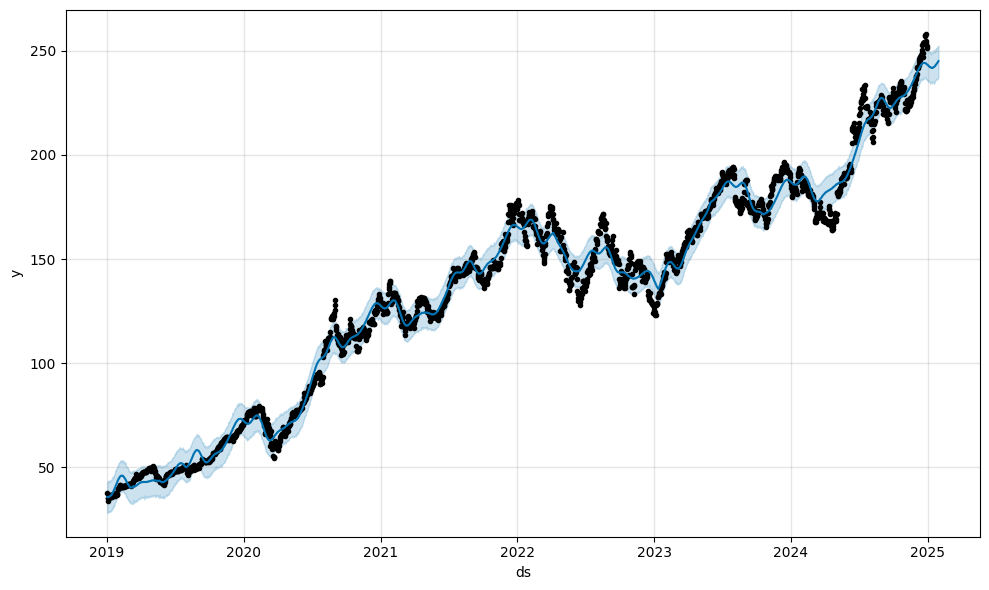

In [ ]:
from prophet import Prophet

df_aapl = prophet_dfs['AAPL']

model = Prophet(daily_seasonality=True)
model.fit(df_aapl)

future = model.make_future_dataframe(periods=30)  # 30 วันข้างหน้า
forecast = model.predict(future)

fig = model.plot(forecast)


In [ ]:
from prophet import Prophet

results = {}

# จำนวนวันที่จะพยากรณ์ล่วงหน้า
forecast_horizon = 30

for ticker in tickers:
    print(f"📊 Training Prophet for {ticker} ...")

    # เตรียมข้อมูล
    df_ticker = flat_df[flat_df['Symbol'] == ticker][['Date', 'Close']].copy()
    df_ticker = df_ticker.rename(columns={'Date': 'ds', 'Close': 'y'})
    df_ticker['ds'] = pd.to_datetime(df_ticker['ds'])
    df_ticker['y'] = pd.to_numeric(df_ticker['y'], errors='coerce')
    df_ticker = df_ticker.dropna()

    if df_ticker.empty:
        print(f"❌ Skipped {ticker}, no valid data")
        continue

    # Fit Prophet
    model = Prophet(daily_seasonality=True)
    model.fit(df_ticker)

    # Forecast
    future = model.make_future_dataframe(periods=forecast_horizon)
    forecast = model.predict(future)

    # เก็บผลลัพธ์
    results[ticker] = {
        "model": model,
        "forecast": forecast,
        "history": df_ticker
    }

    print(f"✅ Done {ticker}: forecast {forecast_horizon} days ahead")

print("\n🎯 Training & Forecasting Completed!")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/tmoq0zkc.json


📊 Training Prophet for AAPL ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/_lgiytrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12674', 'data', 'file=/tmp/tmpjy3yatiu/tmoq0zkc.json', 'init=/tmp/tmpjy3yatiu/_lgiytrg.json', 'output', 'file=/tmp/tmpjy3yatiu/prophet_model_7wpm56h/prophet_model-20251002175105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/zcq8dmnw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/1l5uhq4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.b

✅ Done AAPL: forecast 30 days ahead
📊 Training Prophet for AMD ...


17:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/1nms9v6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/tdm_tifq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6634', 'data', 'file=/tmp/tmpjy3yatiu/1nms9v6p.json', 'init=/tmp/tmpjy3yatiu/tdm_tifq.json', 'output', 'file=/tmp/tmpjy3yatiu/prophet_model2dbeg8pj/prophet_model-20251002175108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Done AMD: forecast 30 days ahead
📊 Training Prophet for APP ...


17:51:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/9ov0oo2b.json


✅ Done APP: forecast 30 days ahead
📊 Training Prophet for AVGO ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/qetqc1os.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39794', 'data', 'file=/tmp/tmpjy3yatiu/9ov0oo2b.json', 'init=/tmp/tmpjy3yatiu/qetqc1os.json', 'output', 'file=/tmp/tmpjy3yatiu/prophet_modelfwk5jp5x/prophet_model-20251002175110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/f3yhbh5k.json


✅ Done AVGO: forecast 30 days ahead
📊 Training Prophet for GOOG ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/ule17256.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41550', 'data', 'file=/tmp/tmpjy3yatiu/f3yhbh5k.json', 'init=/tmp/tmpjy3yatiu/ule17256.json', 'output', 'file=/tmp/tmpjy3yatiu/prophet_model0burvvk1/prophet_model-20251002175112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/kwi9_qsn.json


✅ Done GOOG: forecast 30 days ahead
📊 Training Prophet for GOOGL ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/qo3jxdu3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79363', 'data', 'file=/tmp/tmpjy3yatiu/kwi9_qsn.json', 'init=/tmp/tmpjy3yatiu/qo3jxdu3.json', 'output', 'file=/tmp/tmpjy3yatiu/prophet_modelslpg0c15/prophet_model-20251002175115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/n7gdpdy2.json


✅ Done GOOGL: forecast 30 days ahead
📊 Training Prophet for META ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/5ui6y4_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4898', 'data', 'file=/tmp/tmpjy3yatiu/n7gdpdy2.json', 'init=/tmp/tmpjy3yatiu/5ui6y4_w.json', 'output', 'file=/tmp/tmpjy3yatiu/prophet_model9ztc9tj_/prophet_model-20251002175117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/4cztqo0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/64c8eh7e.json


✅ Done META: forecast 30 days ahead
📊 Training Prophet for MSFT ...


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61682', 'data', 'file=/tmp/tmpjy3yatiu/4cztqo0c.json', 'init=/tmp/tmpjy3yatiu/64c8eh7e.json', 'output', 'file=/tmp/tmpjy3yatiu/prophet_modelydi5wc6_/prophet_model-20251002175119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/7q_1ah13.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/y9_fgw7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19380', 'data', 'file=/tmp/tmpjy3yatiu/7q_

✅ Done MSFT: forecast 30 days ahead
📊 Training Prophet for NVDA ...


17:51:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/v9ptrvtn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjy3yatiu/z58pqyd1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72867', 'data', 'file=/tmp/tmpjy3yatiu/v9ptrvtn.json', 'init=/tmp/tmpjy3yatiu/z58pqyd1.json', 'output', 'file=/tmp/tmpjy3yatiu/prophet_model633me81o/prophet_model-20251002175122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Done NVDA: forecast 30 days ahead
📊 Training Prophet for PLTR ...


17:51:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Done PLTR: forecast 30 days ahead

🎯 Training & Forecasting Completed!


In [ ]:
results['AAPL']['forecast'].tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2215,2025-01-25,246.097272,235.973814,251.666461,245.999482,246.586877,-2.125540,-2.125540,-2.125540,-7.04107,...,-0.014136,-0.014136,-0.014136,4.929666,4.929666,4.929666,0.0,0.0,0.0,243.971732
2216,2025-01-26,246.251017,236.953127,252.408214,246.129042,246.829417,-2.050672,-2.050672,-2.050672,-7.04107,...,-0.046145,-0.046145,-0.046145,5.036542,5.036542,5.036542,0.0,0.0,0.0,244.200344
2217,2025-01-27,246.404761,237.216786,252.405015,246.212561,247.069369,-1.981179,-1.981179,-1.981179,-7.04107,...,-0.078154,-0.078154,-0.078154,5.138044,5.138044,5.138044,0.0,0.0,0.0,244.423581
2218,2025-01-28,246.558505,236.990055,252.849207,246.278875,247.314015,-1.744894,-1.744894,-1.744894,-7.04107,...,0.066529,0.066529,0.066529,5.229647,5.229647,5.229647,0.0,0.0,0.0,244.813611
2219,2025-01-29,246.712250,238.100485,253.055694,246.344858,247.556976,-1.653459,-1.653459,-1.653459,-7.04107,...,0.080772,0.080772,0.080772,5.306839,5.306839,5.306839,0.0,0.0,0.0,245.058790


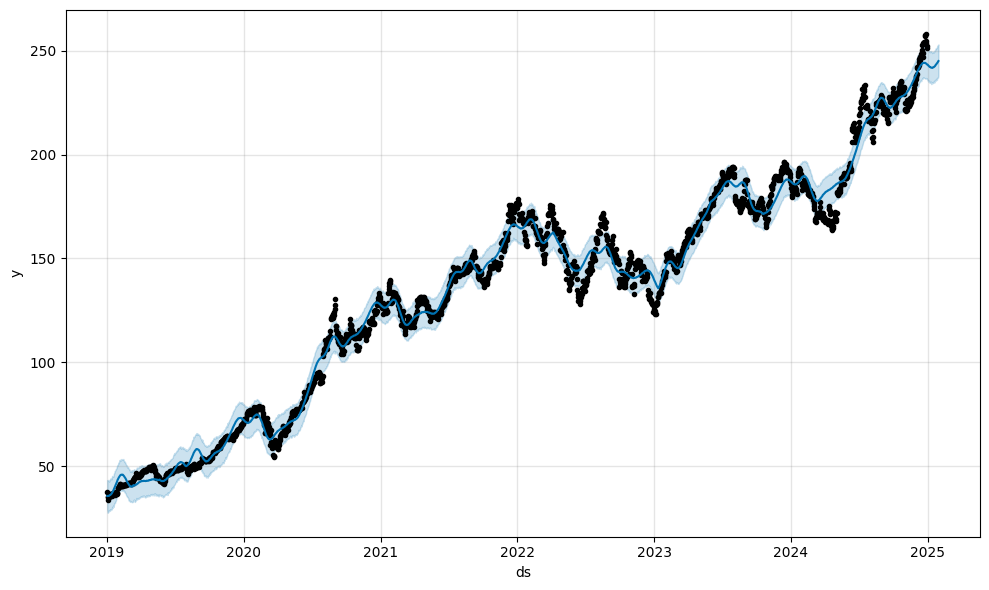

In [ ]:
fig = results['AAPL']['model'].plot(results['AAPL']['forecast'])


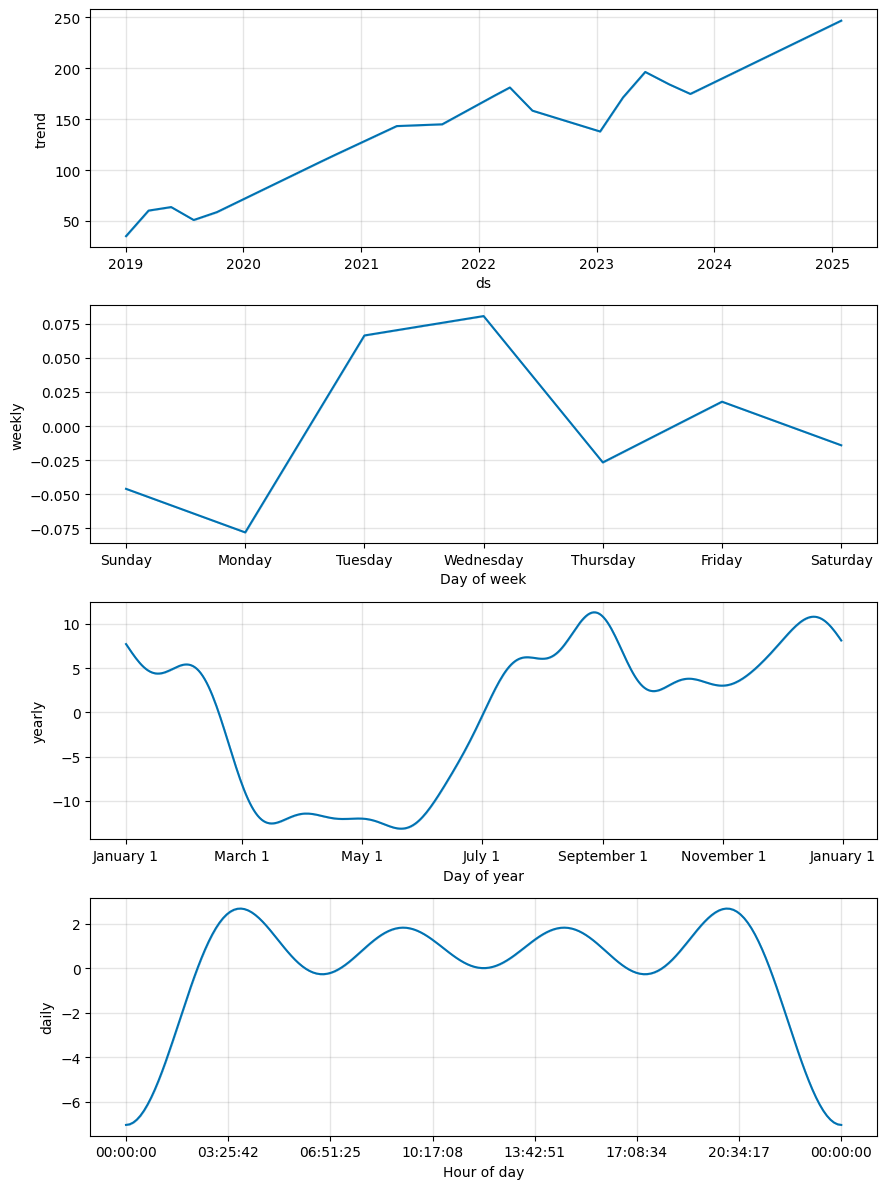

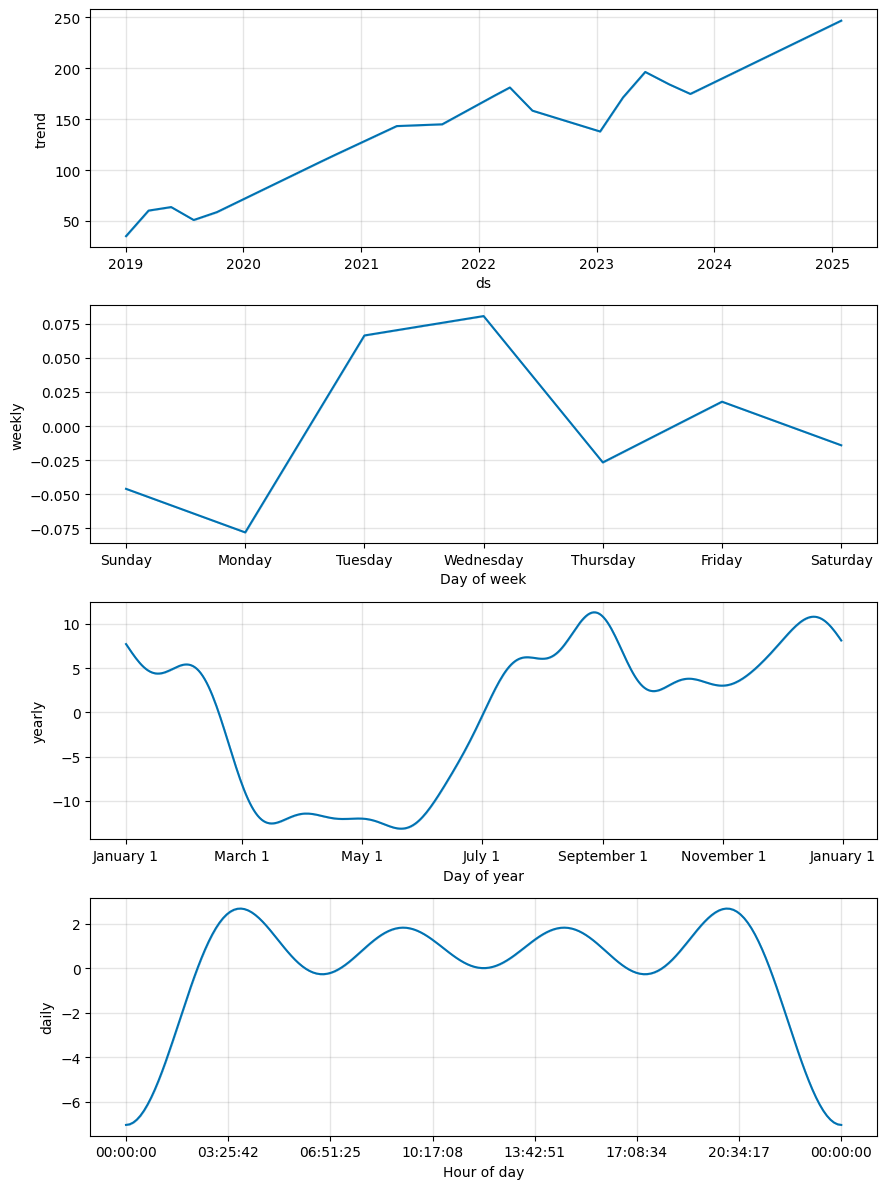

In [ ]:
results['AAPL']['model'].plot_components(results['AAPL']['forecast'])


📈 Plotting AAPL ...


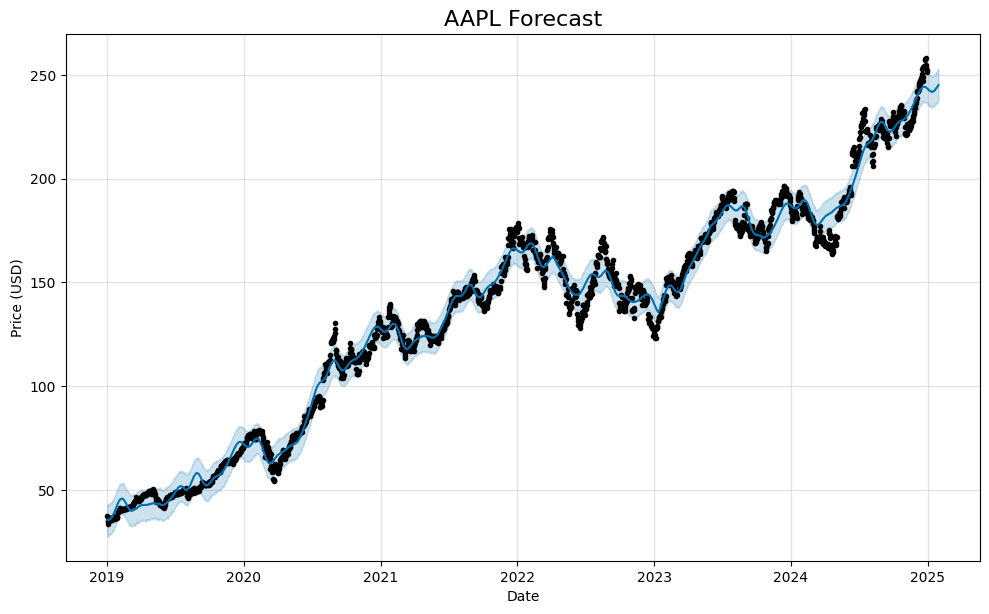

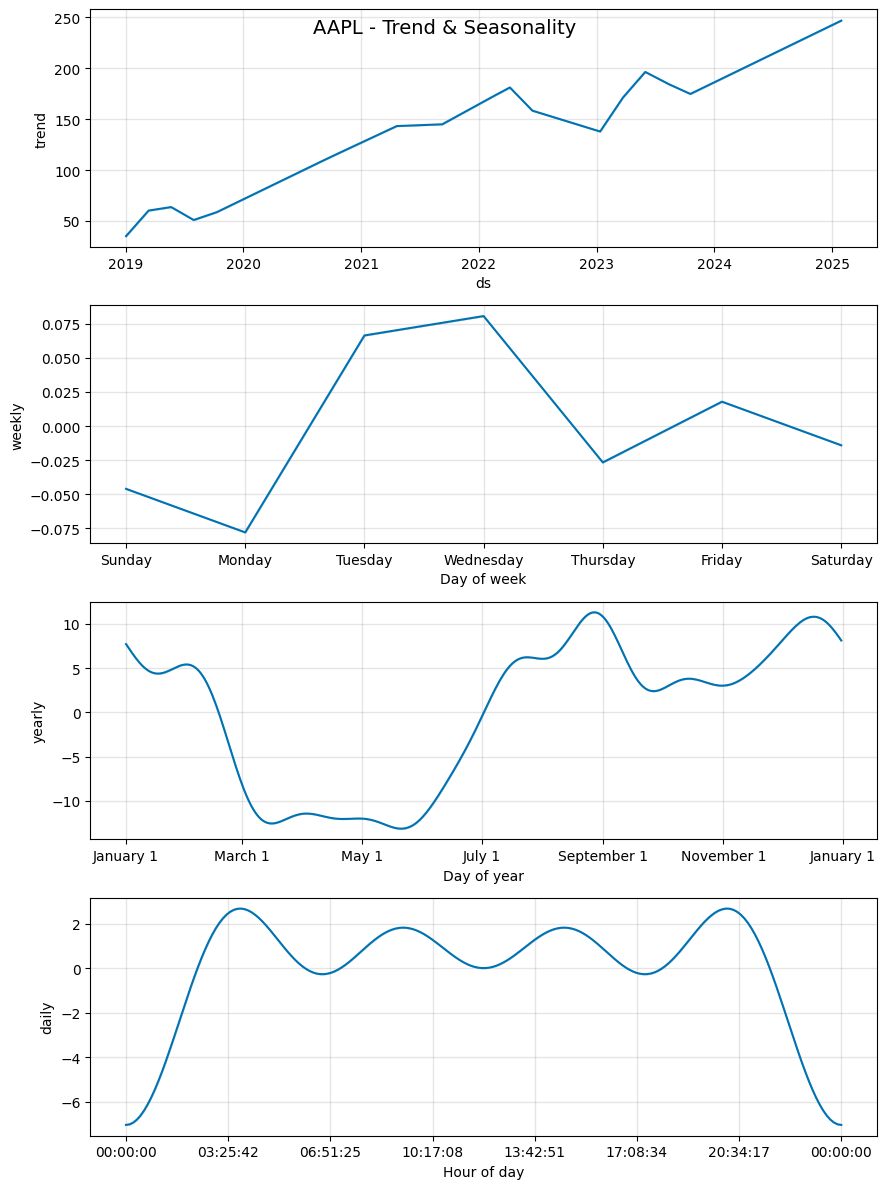

📈 Plotting AMD ...


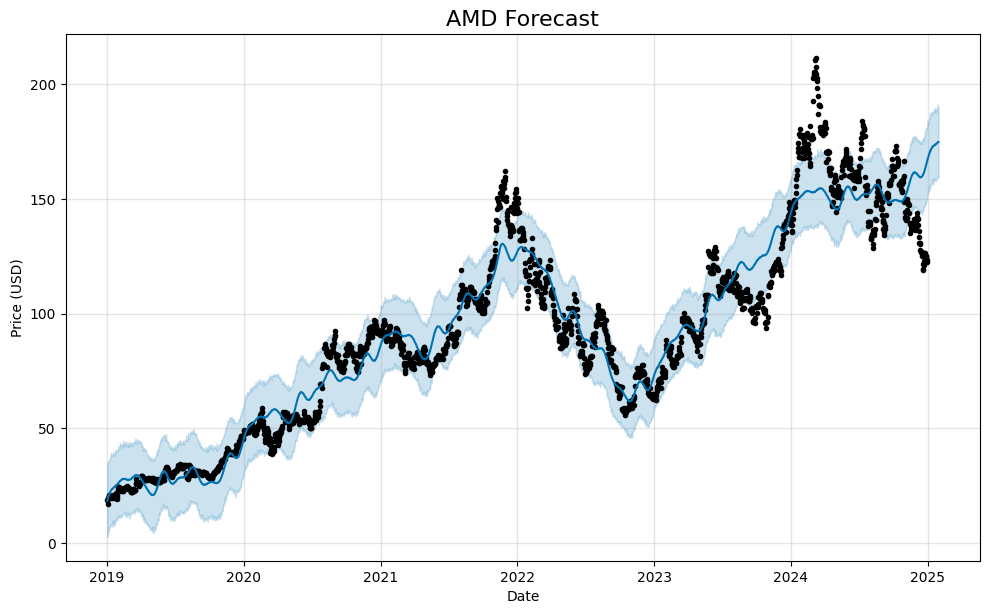

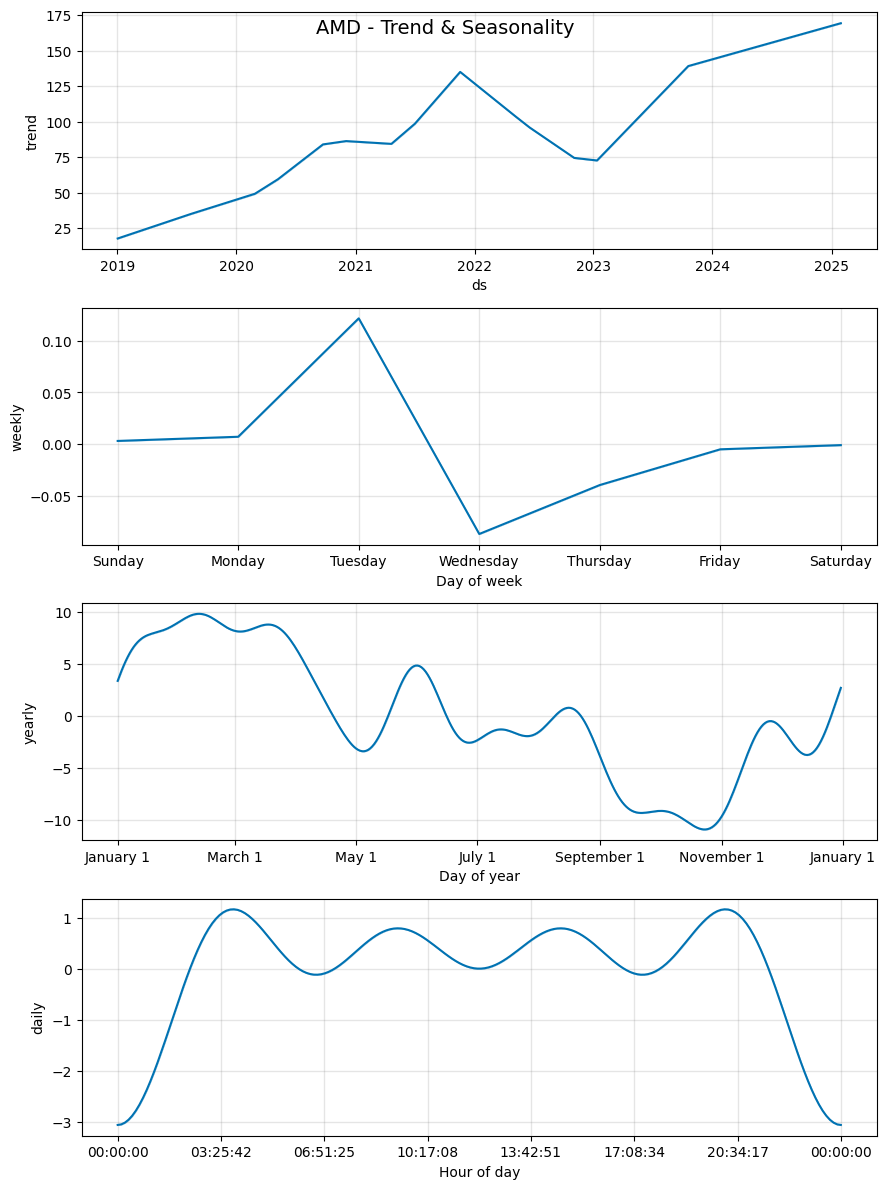

📈 Plotting APP ...


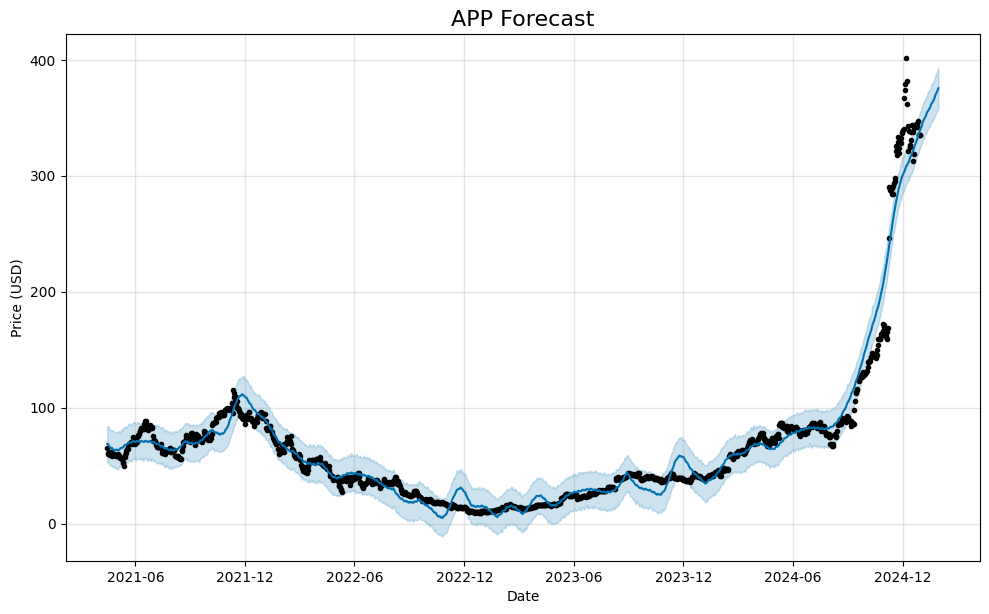

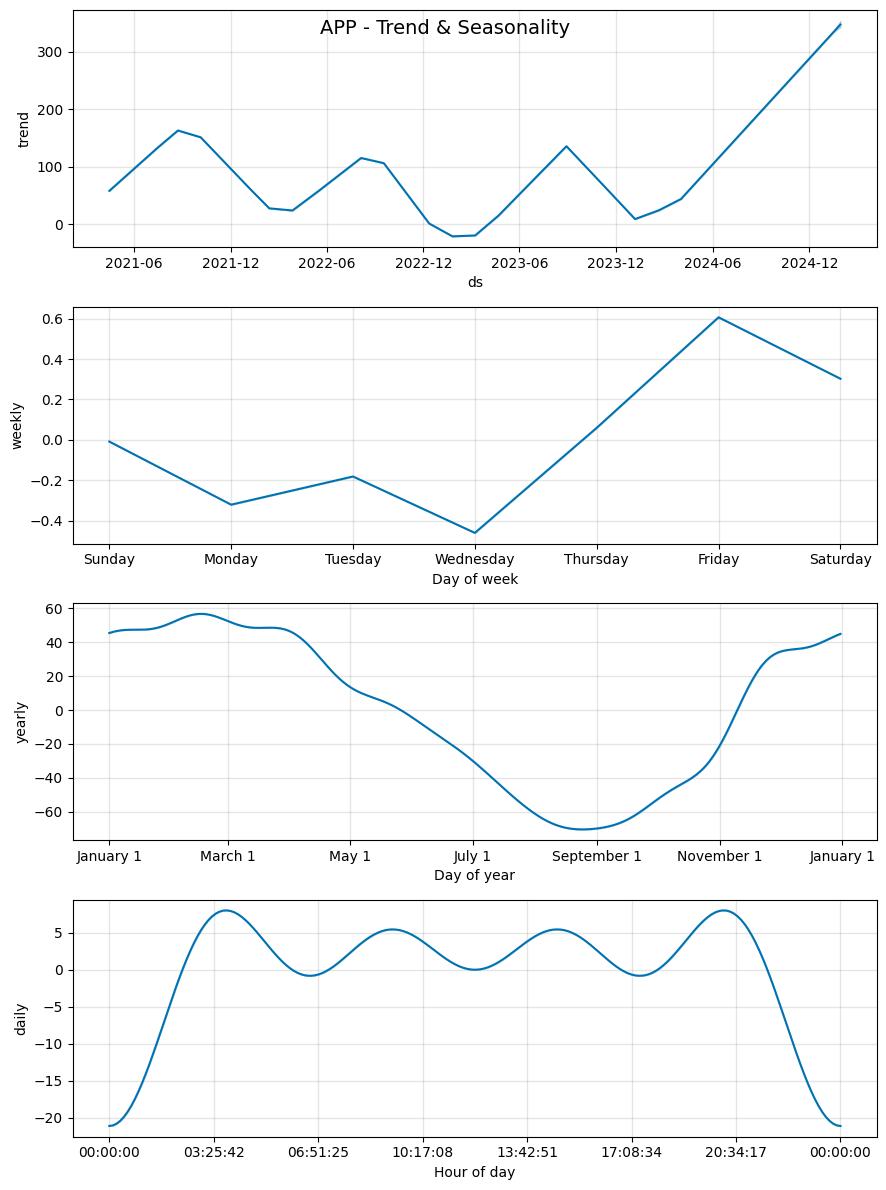

📈 Plotting AVGO ...


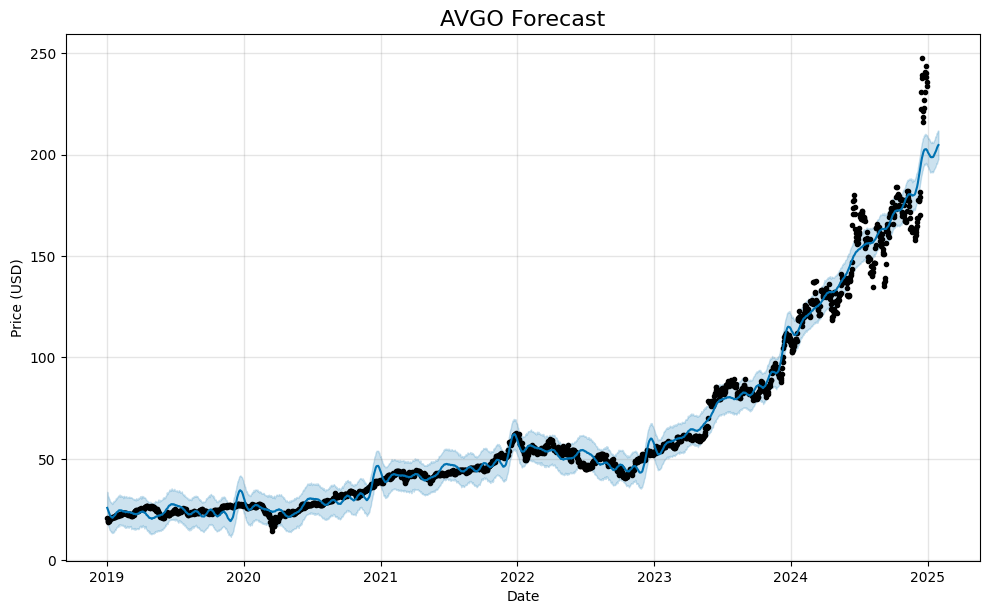

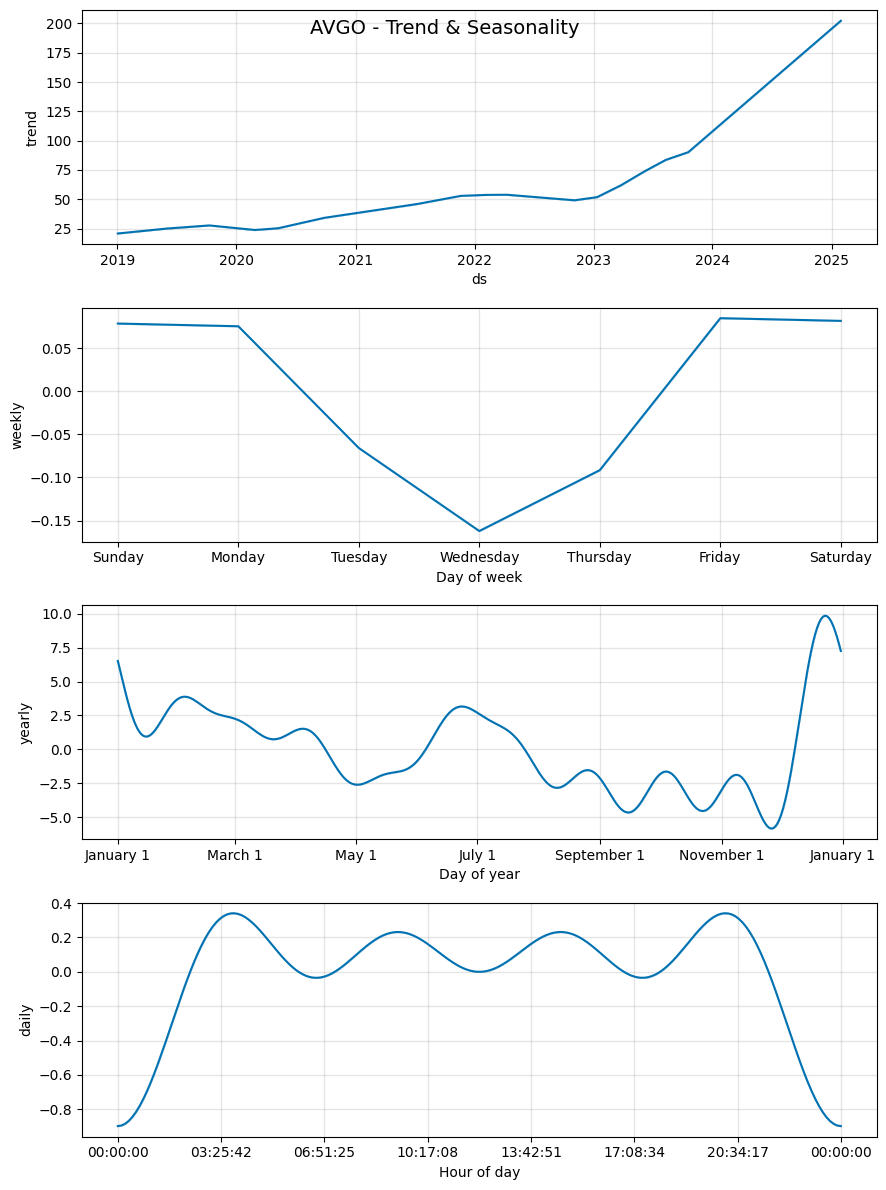

📈 Plotting GOOG ...


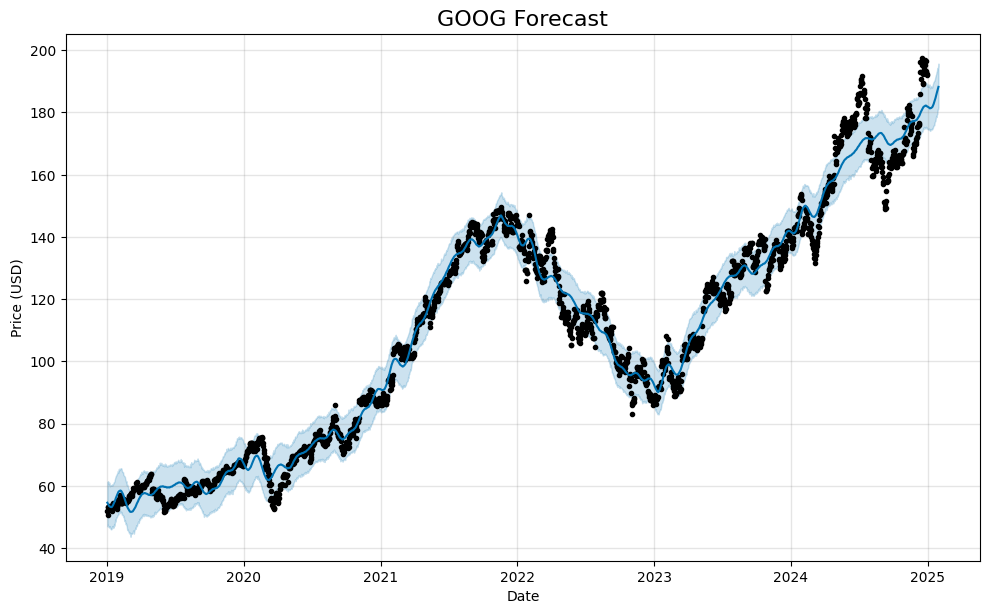

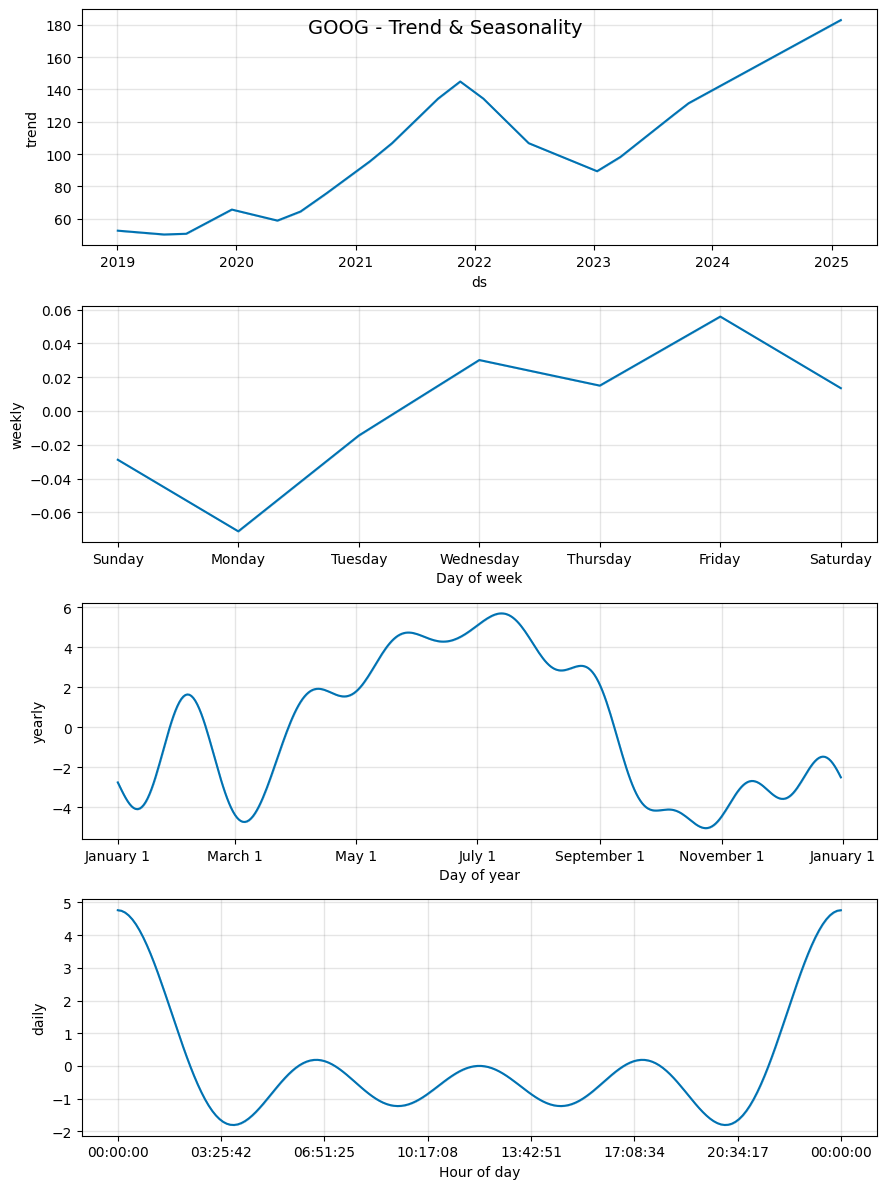

📈 Plotting GOOGL ...


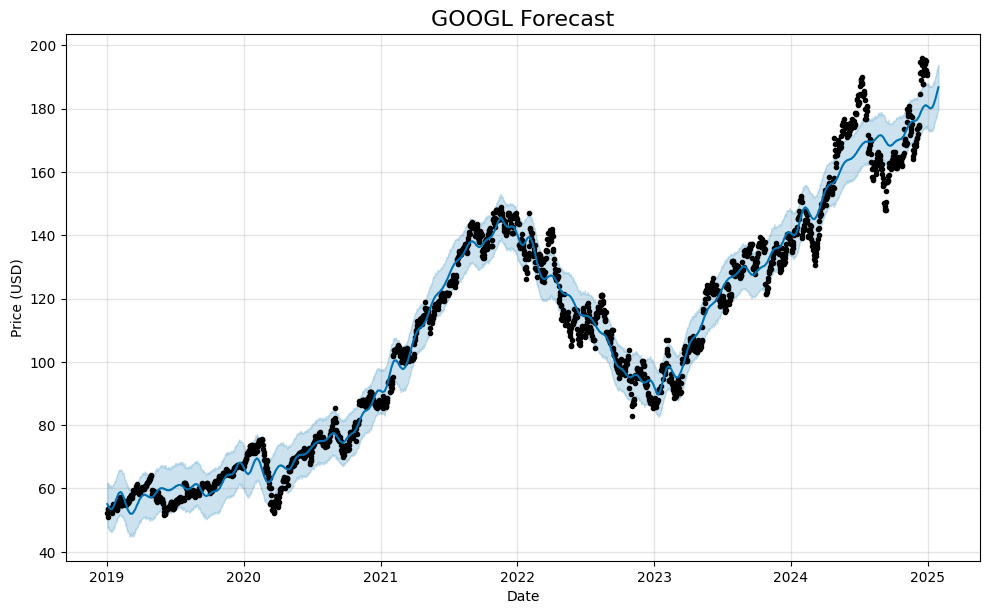

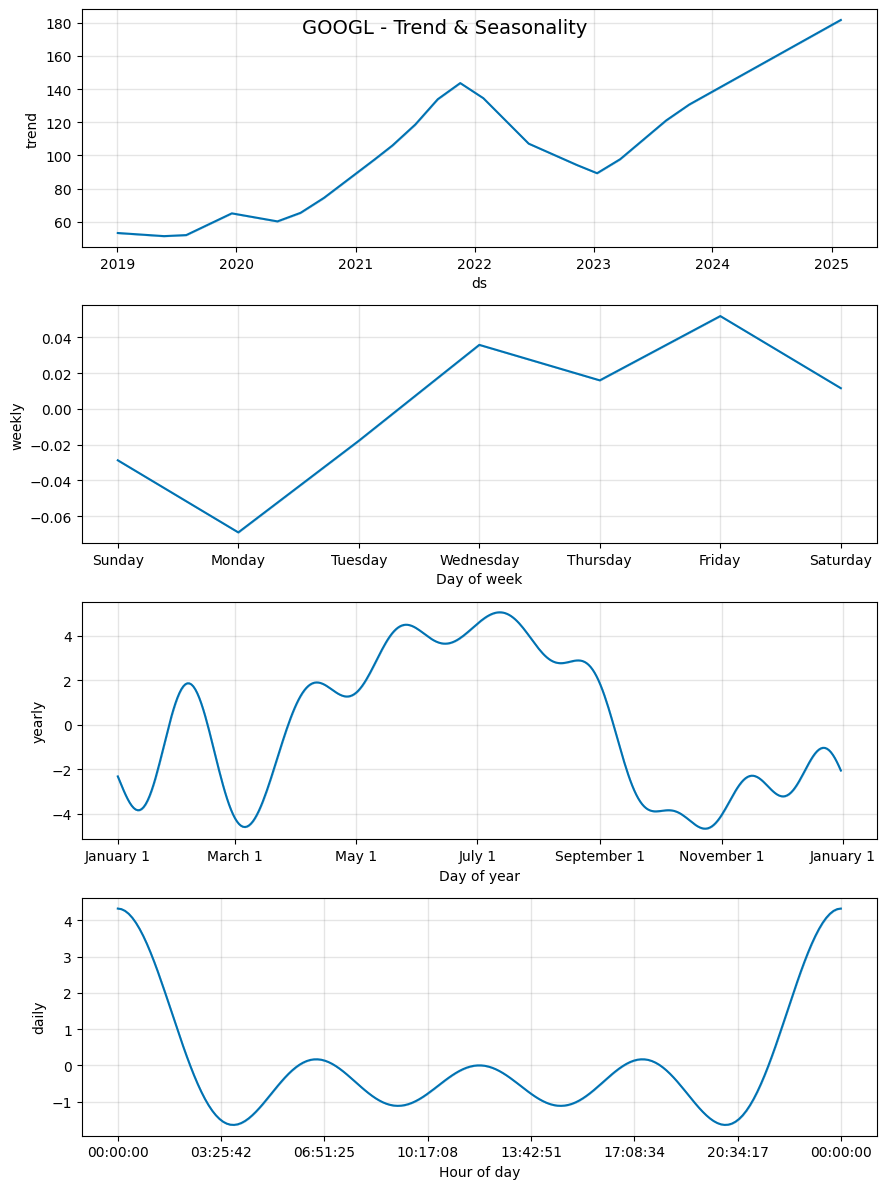

📈 Plotting META ...


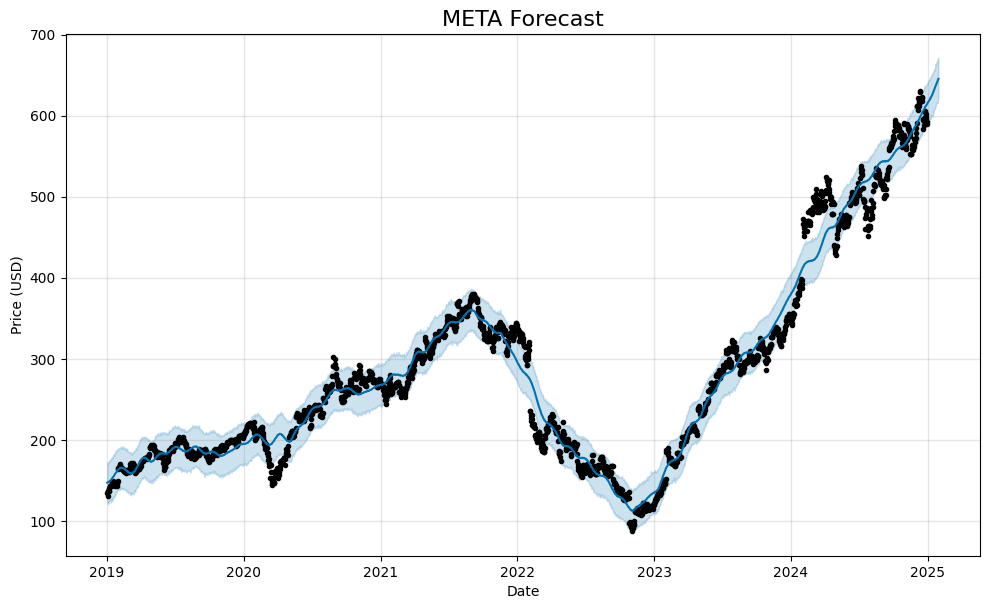

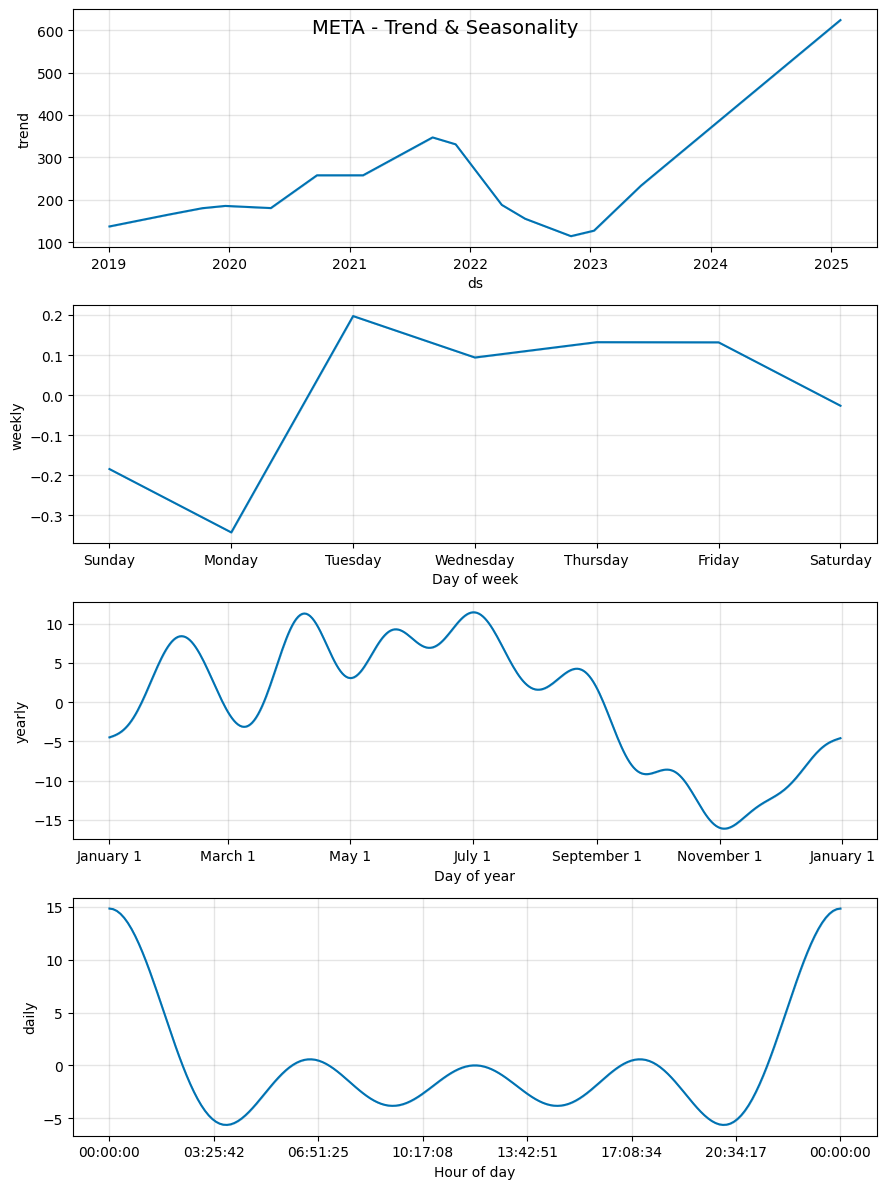

📈 Plotting MSFT ...


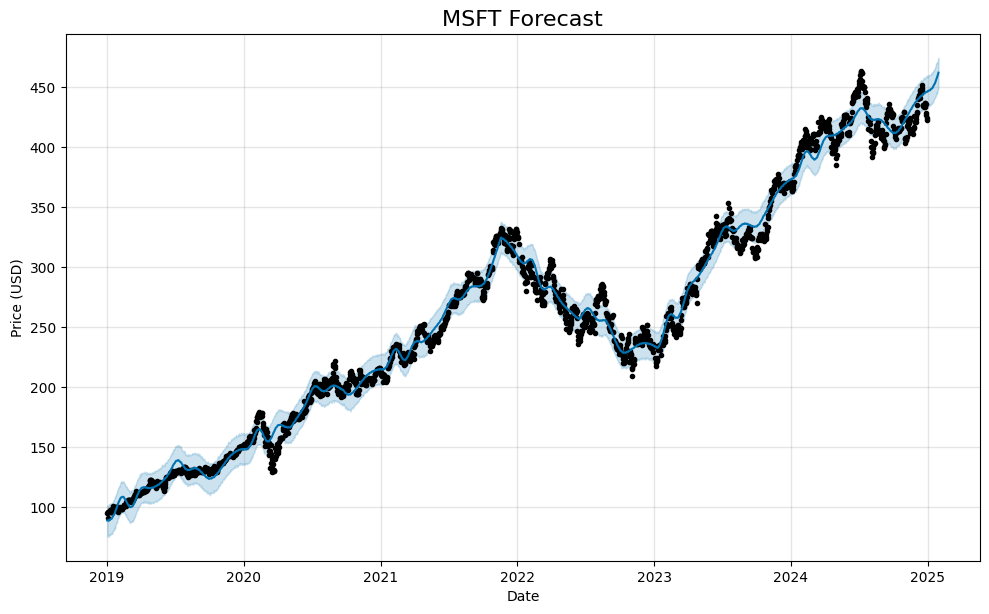

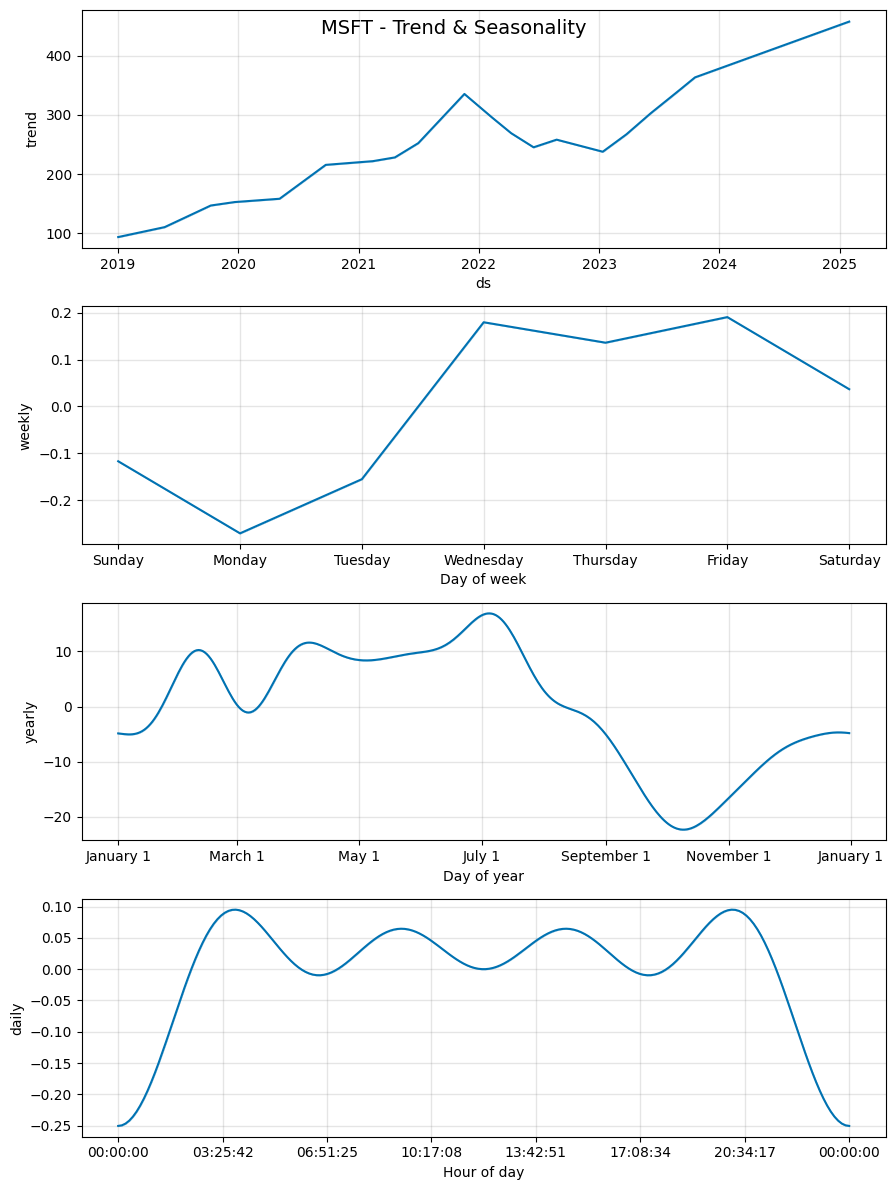

📈 Plotting NVDA ...


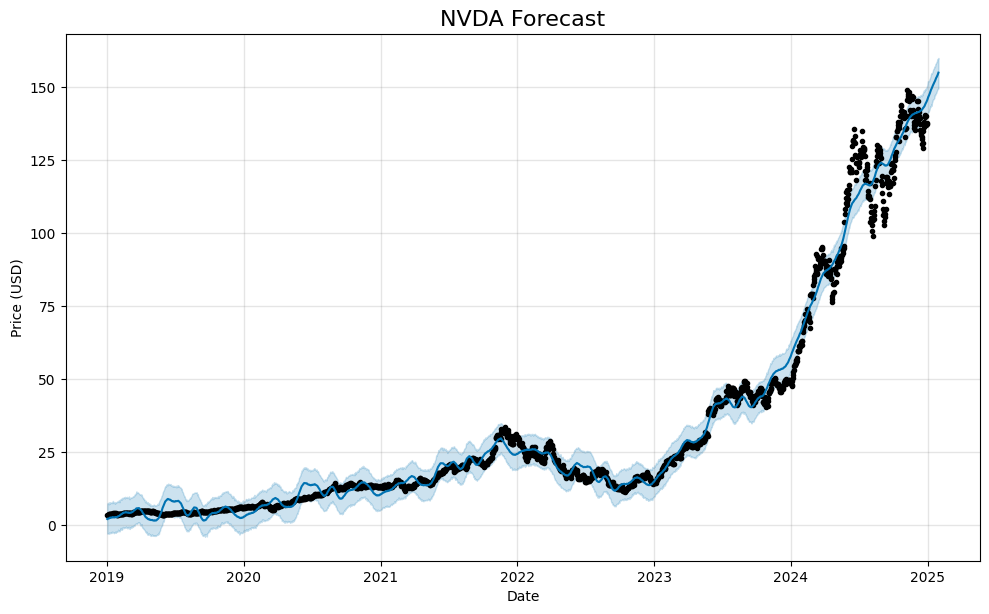

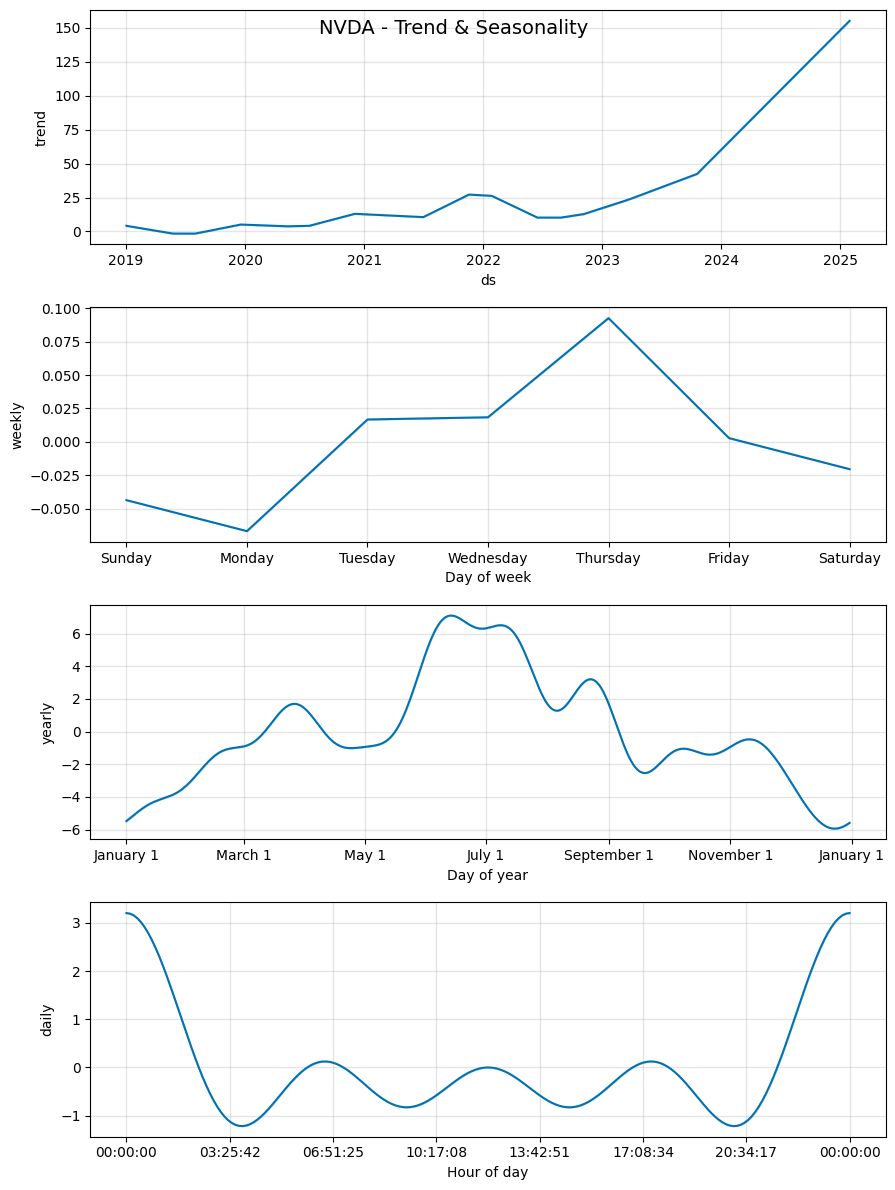

📈 Plotting PLTR ...


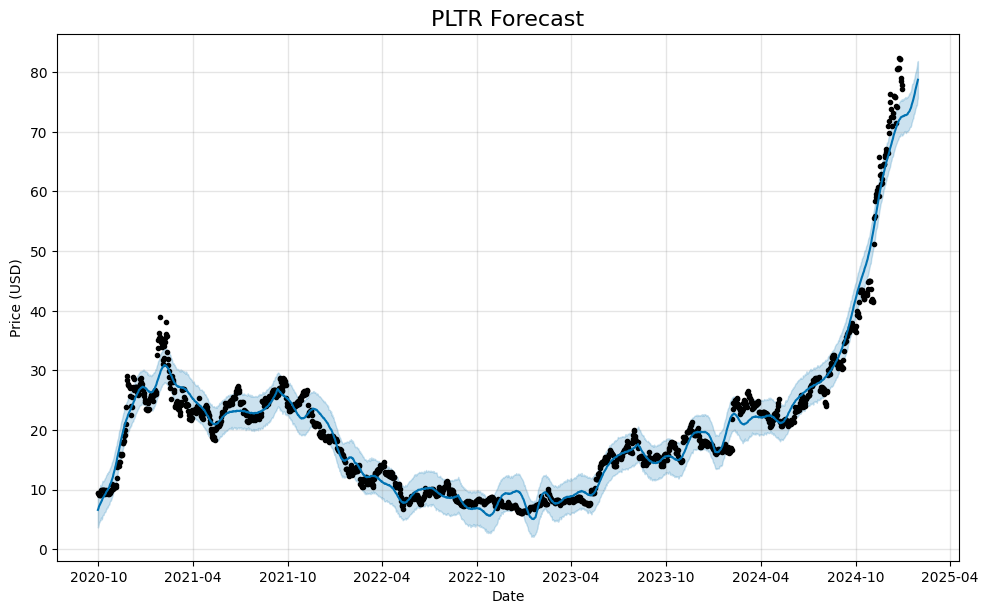

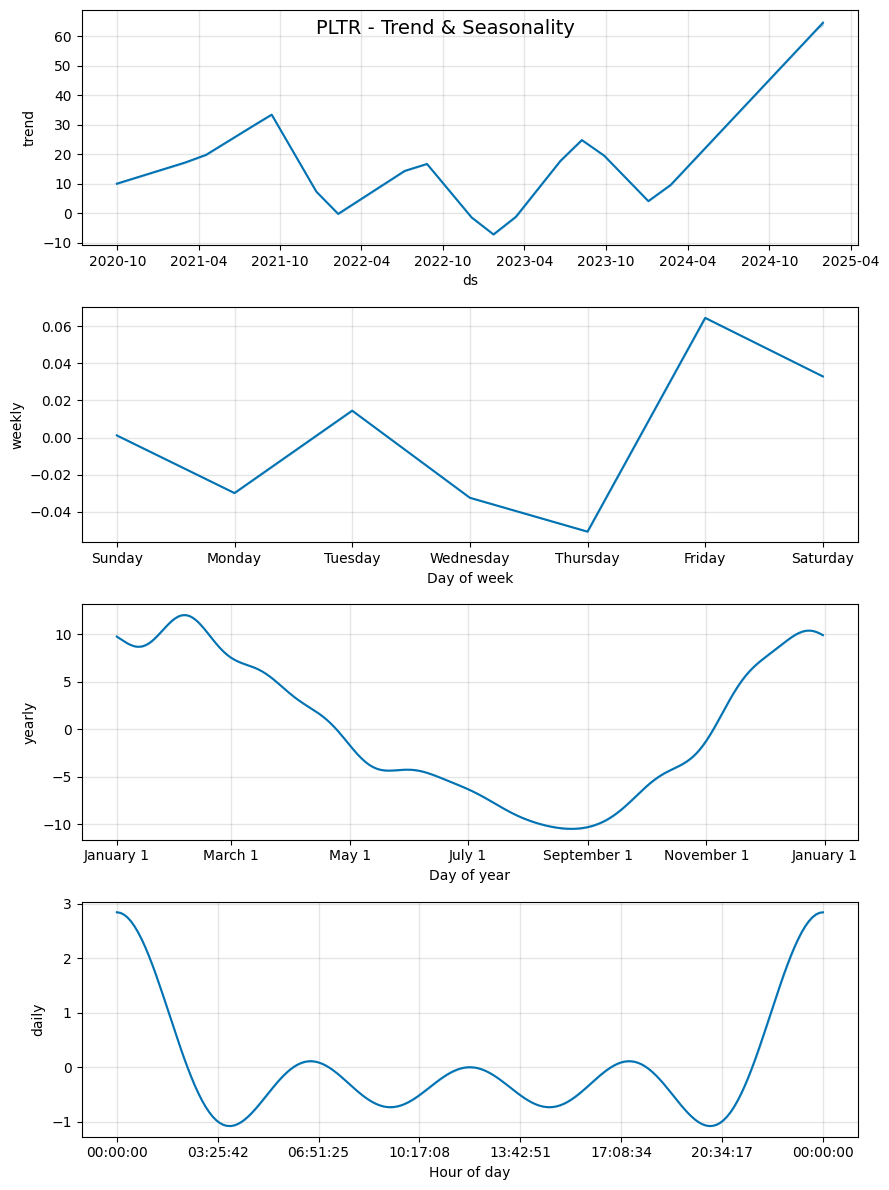

In [ ]:
import matplotlib.pyplot as plt

# วาดกราฟ Forecast ของทุกหุ้น
for ticker in results.keys():
    forecast = results[ticker]['forecast']
    model = results[ticker]['model']
    history = results[ticker]['history']

    print(f"📈 Plotting {ticker} ...")
    fig1 = model.plot(forecast)
    plt.title(f"{ticker} Forecast", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.show()

    # Components (trend + seasonality)
    fig2 = model.plot_components(forecast)
    plt.suptitle(f"{ticker} - Trend & Seasonality", fontsize=14)
    plt.show()




📊 Evaluation Metrics (Prophet):
  Ticker        MAE       RMSE   MAPE (%)        R²
0   AAPL   4.371279   5.741445   3.676353  0.988693
1    AMD   8.859854  11.939729  10.121099  0.922676
2    APP   7.661123  12.063556  16.153817  0.962595
3   AVGO   3.577902   5.692593   6.355188  0.983961
4   GOOG   4.155096   5.434212   3.947645  0.978808
5  GOOGL   4.186362   5.460519   3.990447  0.977984
6   META  14.391363  19.736281   5.471547  0.973852
7   MSFT   7.531324   9.726397   3.024381  0.989855
8   NVDA   2.762964   4.031132  15.812932  0.988166
9   PLTR   1.642722   2.219697   9.556999  0.969548


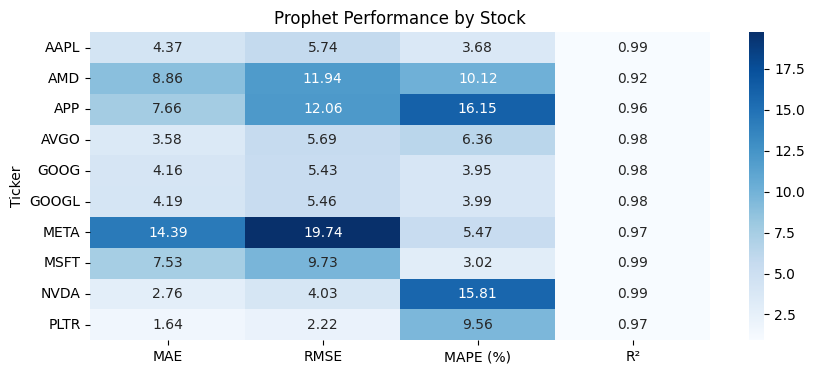

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

metrics_list = []

for ticker in results.keys():
    forecast = results[ticker]['forecast']
    history = results[ticker]['history']

    # ตัด forecast ให้ตรงกับช่วง test (จริง ๆ)
    forecast_df = forecast.set_index("ds").loc[history['ds']].reset_index()
    y_true = history['y'].values
    y_pred = forecast_df['yhat'].values

    # คำนวณ Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    metrics_list.append([ticker, mae, rmse, mape, r2])

# รวมเป็น DataFrame
metrics_df = pd.DataFrame(metrics_list, columns=["Ticker", "MAE", "RMSE", "MAPE (%)", "R²"])
print("\n📊 Evaluation Metrics (Prophet):")
print(metrics_df)

# แสดงตารางสวย ๆ
import seaborn as sns
plt.figure(figsize=(10,4))
sns.heatmap(metrics_df.set_index("Ticker")[["MAE","RMSE","MAPE (%)","R²"]], annot=True, fmt=".2f", cmap="Blues")
plt.title("Prophet Performance by Stock")
plt.show()


In [ ]:
metrics_df.to_csv("LSTM+Probhet+Linear Interpolation.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def run_walkforward_cv(symbol, df, lag=7, n_splits=5):
    # เตรียมข้อมูลสำหรับ Symbol ที่เลือก
    stock_df = df[df['Symbol'] == symbol][['Date', 'Close']].copy()

    # สร้าง lagged features
    for i in range(1, lag+1):
        stock_df[f'lag_{i}'] = stock_df['Close'].shift(i)

    stock_df = stock_df.dropna().reset_index(drop=True)

    if len(stock_df) < lag + n_splits * 2:
        return None  # ข้ามถ้าข้อมูลน้อยเกินไป

    X = stock_df.drop(columns=['Date', 'Close']).values
    y = stock_df['Close'].values

    tscv = TimeSeriesSplit(n_splits=n_splits)
    mae_list, rmse_list, r2_list = [], [], []

    for train_idx, test_idx in tscv.split(X):
        n_total = len(train_idx)
        train_end = int(n_total * 0.7)
        valid_end = int(n_total * 0.85)

        X_train, y_train = X[train_idx[:train_end]], y[train_idx[:train_end]]
        X_valid, y_valid = X[train_idx[train_end:valid_end]], y[train_idx[train_end:valid_end]]
        X_test, y_test = X[test_idx], y[test_idx]

        model = Ridge(alpha=1.0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_list.append(r2_score(y_test, y_pred))

    return {
        "Symbol": symbol,
        "MAE_avg": np.mean(mae_list),
        "RMSE_avg": np.mean(rmse_list),
        "R2_avg": np.mean(r2_list)
    }

# ------------------------------
# รันทุกหุ้นใน full_df
# ------------------------------
symbols = full_df['Symbol'].unique()
results = []

for sym in symbols:
    res = run_walkforward_cv(sym, full_df, lag=7, n_splits=5)
    if res:
        results.append(res)

# แปลงเป็น DataFrame
results_df = pd.DataFrame(results)

# ปัดทศนิยมทุก column เป็น 4 ตำแหน่ง
results_df = results_df.round(4)

# Export CSV
results_df.to_csv("walkforward_all_symbols.csv", index=False, encoding="utf-8-sig")

# Export Excel
results_df.to_excel("walkforward_all_symbols.xlsx", index=False)

print("✅ Export เสร็จสิ้น → walkforward_all_symbols.csv / .xlsx")



✅ Export เสร็จสิ้น → walkforward_all_symbols.csv / .xlsx


In [ ]:
results_df

,Symbol,MAE_avg,RMSE_avg,R2_avg
0,AAPL,1.4249,2.0434,0.9836
1,AMD,1.7913,2.6895,0.9791
2,APP,1.5524,2.8545,0.9877
3,AVGO,1.0423,1.6252,0.9754
4,GOOG,1.2536,1.8314,0.9831
5,GOOGL,1.2514,1.8295,0.9830
6,META,3.6986,5.9374,0.9844
7,MSFT,2.6281,3.7972,0.9733
8,NVDA,0.6824,0.9981,0.9880
9,PLTR,0.4271,0.6708,0.9742


In [ ]:
!pip install tensorflow ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=31537d86ada29340340d77a97e37b4bb874f0bc4ea9b085142b55c821c69b1c5
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ============================
# 1) เตรียมข้อมูล Sequence
# ============================
feature_cols = ['SMA_20','SMA_50','EMA_20','EMA_50',
                'BB_middle','BB_upper','BB_lower','RSI_14']

scaler = StandardScaler()
flat_df_clean[feature_cols] = scaler.fit_transform(flat_df_clean[feature_cols])

def create_sequences(symbol_df, seq_len=30):
    X, y = [], []
    data = symbol_df[feature_cols].values
    target = symbol_df['Close_next'].values
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

# ตัวอย่างกับหุ้น AAPL
symbol = "AAPL"
df_sym = flat_df_clean[flat_df_clean['Symbol'] == symbol].dropna()
X, y = create_sequences(df_sym, seq_len=30)

# Split 70/15/15
n = len(X)
train_end = int(0.7*n)
valid_end = int(0.85*n)

X_train, y_train = X[:train_end], y[:train_end]
X_valid, y_valid = X[train_end:valid_end], y[train_end:valid_end]
X_test, y_test   = X[valid_end:], y[valid_end:]

# ============================
# 2) สร้าง LSTM Model
# ============================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ============================
# 3) Train
# ============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=32,
    verbose=1
)

# ============================
# 4) Evaluate
# ============================
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")


NameError: name 'flat_df_clean' is not defined

In [ ]:
!pip install tensorflow ta

In [ ]:
!pip install tensorflow ta
# -----------------------------------------------------------------------------
# 0) Import Libraries
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------------------------------------------------------
# 1) เตรียมข้อมูล
# -----------------------------------------------------------------------------
feature_cols = ['SMA_20','SMA_50','EMA_20','EMA_50',
                'BB_middle','BB_upper','BB_lower',]

flat_df_scaled = flat_df_clean.copy()
scaler = StandardScaler()
flat_df_scaled[feature_cols] = scaler.fit_transform(flat_df_scaled[feature_cols])

def create_sequences(symbol_df, seq_len=30):
    X, y = [], []
    data = symbol_df[feature_cols].values
    target = symbol_df['Close_next'].values
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

# -----------------------------------------------------------------------------
# 2) ฟังก์ชัน Train & Evaluate LSTM
# -----------------------------------------------------------------------------
def run_lstm_for_symbol(symbol, seq_len=30, epochs=50, batch_size=32):
    df_sym = flat_df_scaled[flat_df_scaled['Symbol'] == symbol].dropna()
    if len(df_sym) < seq_len + 50:
        return None  # ข้ามถ้าข้อมูลน้อยเกินไป

    X, y = create_sequences(df_sym, seq_len=seq_len)

    # Split 70/15/15
    n = len(X)
    train_end = int(0.7*n)
    valid_end = int(0.85*n)

    X_train, y_train = X[:train_end], y[:train_end]
    X_valid, y_valid = X[train_end:valid_end], y[train_end:valid_end]
    X_test, y_test   = X[valid_end:], y[valid_end:]

    # LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0  # ไม่ต้องแสดง progress
    )

    # Predict
    y_pred = model.predict(X_test, verbose=0).flatten()

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        "Symbol": symbol,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

# -----------------------------------------------------------------------------
# 3) รันทุก Symbol
# -----------------------------------------------------------------------------
symbols = flat_df_scaled['Symbol'].unique()
results = []

for sym in symbols:
    print(f"📈 Training {sym} ...")
    res = run_lstm_for_symbol(sym, seq_len=30, epochs=50, batch_size=32)
    if res:
        results.append(res)
        print(f"✅ Done {sym} → MAE={res['MAE']:.4f}, RMSE={res['RMSE']:.4f}, R2={res['R2']:.4f}")
    else:
        print(f"⚠️ Skip {sym} (not enough data)")

# -----------------------------------------------------------------------------
# 4) Export Results
# -----------------------------------------------------------------------------
results_df = pd.DataFrame(results).round(4)
results_df.to_csv("lstm_all_symbols.csv", index=False, encoding="utf-8-sig")
results_df.to_excel("lstm_all_symbols.xlsx", index=False)

print("✅ Export เสร็จสิ้น → lstm_all_symbols.csv / .xlsx")


